# Sample Analysis with Example Data

## Einleitung

In dieser Analyse betrachten wir die Shift-Daten von Eishockeyspielern anhand von Beispieldaten eines Event Exports des Anbieters Kinexon, um Einblicke in die Spielstrategien und die Leistung der Spieler zu gewinnen. 

Durch die Untersuchung von Shift-Längen, Intensitäten und Pausen zwischen den Shifts können wir die Ausdauer und Effektivität der Spieler im Verlauf des Spiels bewerten. Die Nutzung von `utils.py` ermöglicht uns eine effiziente Datenverarbeitung und Visualisierung.

Ziel dieses Notebooks ist es, potenziellen Nutzer des Algorithmus einen Einblick in die Art der durchgeführten Analysen und die daraus resultierenden Erkenntnisse zu geben.


## 1. Data Loading

Zuerst laden wir die Shift-Daten mit der Funktion `read_file`. Diese Funktion extrahiert die relevanten Informationen aus den exportierten Event-Daten und bereitet sie für die Analyse vor.


In [1]:
%load_ext autoreload
%autoreload 2

# Zugriff auf die Funktionen in utils.py
import utils

# import der notwendigen Funktionen für Data Loading
from utils import read_file

In [2]:
# Definieren des Dateipfads und des Event-Typs
file_name = 'data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv'
event_type = 'Shifts'

# Laden der Daten mit der read_file Funktion aus utils.py
df = read_file(file_name, event_type)

# Anzeigen der ersten Zeilen des DataFrame zur Überprüfung
df.head()

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,337.08,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,413.47,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,0.00,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,0.00,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.93,4.64,0.49,1.47


## 2. Shift Analysis

Nachdem wir einen Überblick über die Shift-Daten gewonnen und diese visuell dargestellt haben, ist der nächste Schritt, tiefer in die Analyse der Shifts einzusteigen. 

Dieses Kapitel konzentriert sich auf die detaillierte Untersuchung der Shifts, beginnend mit der Bestimmung der optimalen Anzahl von Shifts pro Spieler. Die Analyse der Shift-Länge, der Zeit zwischen den Shifts und der Intensität der einzelnen Shifts ermöglicht es uns, die Belastung und Leistung der Spieler während des Spiels zu verstehen. Die Identifizierung der optimalen Anzahl von Shifts ist ein entscheidender Schritt, um die Daten effektiv zu segmentieren und präzise Einblicke in die Spielstrategien zu gewinnen.

### 2.1 Optimale Anzahl von Shifts

Um die Shifts effektiv zu analysieren, müssen wir zunächst die optimale Anzahl von Shifts bestimmen. Die Funktion `find_optimal_amount_of_shifts` verwendet hierfür entweder eine Kombination aus der Elbow-Methode und K-Means-Clustering, um die ideale Cluster-Anzahl für unsere Shift-Daten zu ermitteln, oder eine einfache Methode, die auf der Anzahl der Spieler basiert. Letztere Methode funktioniert üblicherweise besser, wie wir später sehen werden.

In [3]:
from utils import find_optimal_amount_of_shifts

# Bestimmen der optimalen Anzahl von Shifts
optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=True, verbose=False)
print(f"Optimale Anzahl von Shifts - simple: {optimal_shifts}")

optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=False, verbose=False)
print(f"Optimale Anzahl von Shifts - elbow: {optimal_shifts}")

Optimale Anzahl von Shifts - simple: 143
Optimale Anzahl von Shifts - elbow: 93


### 2.2 Shift Intensität

#### 2.2.1 Vorbereitung des Dataframes

Bevor wir mit der Visualisierung beginnen, müssen wir sicherzustellen, dass das Dataframe alle erforderlichen Informationen enthält. Dies umfasst Spieler-IDs, Zeitstempel für jeden Shift, die Dauer der Shifts und die entsprechenden Intensitäten.

Ausserdem sollten die Torhüter entfernt werden, da diese zu keiner Shift gehören.

Zuletzt wird nur ein Team betrachtet, um die Visualisierung übersichtlich zu halten.

In [4]:
# Check for required columns
if not {"Timestamp (ms)", "Duration (s)", "Player ID", "Skating Intensity"}.issubset(df.columns):
    raise ValueError("The DataFrame does not contain the necessary columns for visualization.")
else:
    print("All required columns are present in the DataFrame.")
    
# Remove goalkeepers    
df = df[~df["Name"].str.contains("Goalkeeper")]

# Choose team
df_guest = df[df["Name"].str.contains("Guest")]

All required columns are present in the DataFrame.


#### 2.2.2 Visualisierung der Shift Intensität

Mit der Funktion `plot_shifts_with_intensity` erstellen wir eine Visualisierung, die die Shifts aller Spieler zusammen mit der Intensität jedes individuellen Shifts zeigt. Die Funktion `get_colour` wird verwendet, um die Intensität der Shifts farblich zu kodieren, was uns hilft, die physische Belastung der Spieler visuell zu erfassen.

Diese Visualisierung hilft uns, Muster in den Spielerwechseln und deren Auswirkungen auf die Spielintensität zu erkennen.

Shift Intensities using simple method


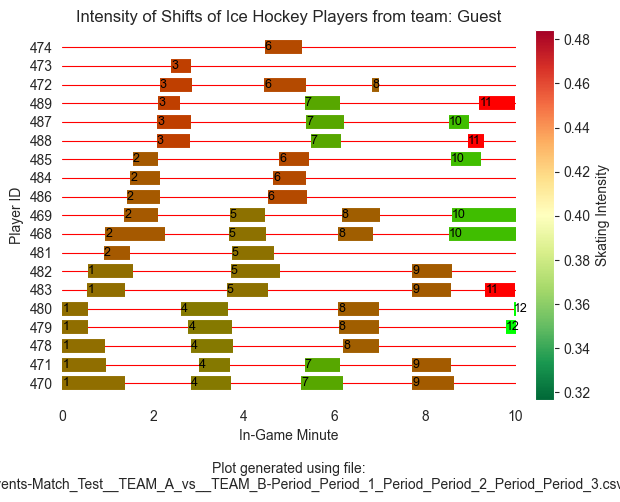

Shift Intensities using elbow method


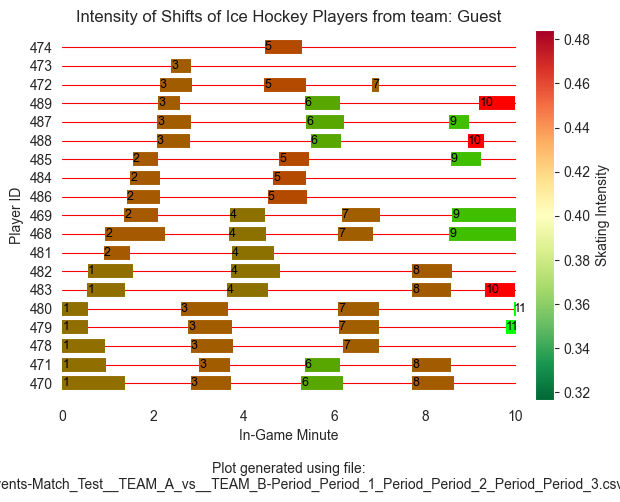

In [5]:
from utils import generate_block_config, plot_shifts_with_intensity

# Generieren der Block-Konfiguration für die Visualisierung
block_config = generate_block_config(
    naive=True,  # Oder False, je nach Analyse
    verbose=False,
    team_name="Guest",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

# Erstellen der Visualisierung mit der naiven Methode
print("Shift Intensities using simple method")
df_guest_intensities = plot_shifts_with_intensity(
    df_guest, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

# Zum Vergleich, die Shifts mit der elbow-method
print("Shift Intensities using elbow method")
block_config[utils.BLOCK_CONFIG_NOF_SHIFTS_DESCRIPTOR] = False
_ = plot_shifts_with_intensity(
    df_guest, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)


Wir in den beiden Grafiken erkennen, liefert die "simple" Methode zum Shifts erkennen bessere Resultate. 

#### 2.2.3 Shift Intensity Score (SIS)

Die Intensität jedes Shifts gibt uns Aufschluss über die Anstrengung und Leistung der Spieler während ihrer Einsatzzeit. Mit der Funktion `add_sis_column` berechnen wir einen Shift Intensity Score (SIS) für jeden Spieler, der die durchschnittliche Intensität ihrer Shifts widerspiegelt.

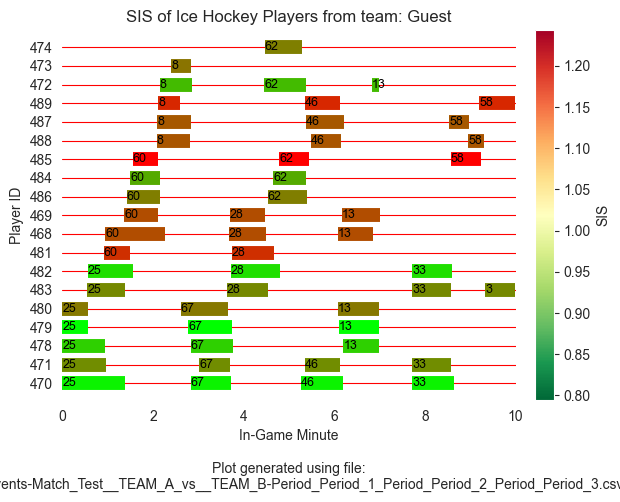

In [6]:
from utils import add_sis_column, plot_SIS

# Berechnung des Shift Intensity Score (SIS) für jeden Spieler
df_with_sis = add_sis_column(df)

# Optional: Anzeigen der ersten Zeilen des angereicherten DataFrames zur Überprüfung
# print(df_with_sis.head())

# Plot SIS
plot_SIS(df_with_sis,
         0,
         10,
         team_name="Guest",
         file_name_raw_data=file_name
         )

## Abschluss und Ausblick

Die Analyse der Shift-Daten bietet wertvolle Einblicke in die physische Leistungsfähigkeit und das strategische Vorgehen der Spieler im Eishockey. Durch die Anwendung von Funktionen aus `utils.py` können die Daten effizient geladen, verarbeitet und visualisiert werden. Zukünftige Untersuchungen könnten weitere Metriken und Spielphasen einbeziehen, um die Analyse noch detaillierter zu gestalten.
